<a href="https://colab.research.google.com/github/LaraNegri/EntregasPDI/blob/main/TrabajoFinal_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importo librerías

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import imageio as io

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Funciones a utilizar

In [2]:
# Función para leer una imagen y tenerla como Array numpy sin limitación uint8
def get_image(rute):
  im = io.imread(rute)
  im = im.astype(np.float)
  return im

#función para pasar una imagen de RGBA a YIQ
def rgbatoyiq(im):
    Shape = im.shape
    im_YIQ = np.zeros((Shape[0], Shape[1], 3))
    [im_YIQ[:,:,0], im_YIQ[:,:,1], im_YIQ[:,:,2]] = (np.matmul(np.array([[0.299, 0.587, 0.114],
              [0.595716, -0.274453, -0.321263],
              [0.211456, -0.522591, 0.311135]]), (np.array([im[:,:,0], im[:,:,1], im[:,:,2]])/255).transpose(1,0,2))).transpose(1,0,2)
    im_YIQ[:,:,0] = np.clip(im_YIQ[:,:,0], 0, 1)
    im_YIQ[:,:,1] = np.clip(im_YIQ[:,:,1], -0.5957, 0.5957)
    im_YIQ[:,:,2] = np.clip(im_YIQ[:,:,2], -0.5226, 0.5226)
    return im_YIQ

def yiqtorgb(im):
    Shape = im.shape
    im_RGB = np.zeros((Shape[0], Shape[1], 3))
    [im_RGB[:,:,0], im_RGB[:,:,1], im_RGB[:,:,2]] = 255*(np.matmul(np.array([[1, 0.9663, 0.6210],
              [1, -0.2721, -0.6474],
              [1, -1.1070, 1.7046]]), (np.array([im[:,:,0], im[:,:,1], im[:,:,2]])).transpose(1,0,2))).transpose(1,0,2)
    im_RGB = im_RGB.astype(np.uint8)
    im_RGB[:,:,:] = np.clip(im_RGB[:,:,:], 0, 255)
    return im_RGB

def pixel_analisis(im, i_values, j_values, gotas_list, rcm_gotas, perimetros_tot_gota):
    nro_neighbour = []

    #Ahora que la imagen está binarizada, debo ubicar dónde están los píxeles con luminancia 1 (es decir, mis manchas)
    first_pix_xy = (np.where(im_YIQ_new == 1)[0][0], np.where(im_YIQ_new == 1)[1][0]) #Coordenadas de un pixel aleatorio donde Y = 1
    
    #¿Qué luminancia tienen sus vecinos?

    pixels_coord_list = [] #lista con coordenadas de puntos con Y = 1
    checked = [] #los pixeles que voy chequeando les asigno valor 1
    tmp_pixels_coord_list = [] #hago una lista temporal donde guardo SOLO los pixeles que faltan chequear. Los que ya chequee
    #aparecen en pixels_coord_list, pero los borro de esta, para no chequear dos veces lo mismo
    
    pixels_coord_list.append([first_pix_xy[0], first_pix_xy[1]])
    tmp_pixels_coord_list.append([first_pix_xy[0], first_pix_xy[1]])
    
    while len(checked) < len(pixels_coord_list): #cuando ya chequee todos los pixeles, termina
     
      for pixel in tmp_pixels_coord_list:
        vecinos = -1
        for i in i_values:
          for j in j_values:
            x, y = pixel[0]+i, pixel[1]+j
            currPix = [x, y]
            if im_YIQ_new[x, y, 0]==1 and currPix not in pixels_coord_list:
              pixels_coord_list.append(currPix)
              tmp_pixels_coord_list.append(currPix)
            if im_YIQ[x, y, 0]==1:
                vecinos += 1
        
        nro_neighbour.append(vecinos) 
        checked.append(1) #los pixeles que pasaron por este for, ya fueron chequeados
        tmp_pixels_coord_list.remove(tmp_pixels_coord_list[tmp_pixels_coord_list.index(pixel)])
        im_YIQ_new[pixel[0], pixel[1]] = 0 #los que ya chequee, les pongo luminancia = 0, para ya sacarlos de la imagen
        
    perimetro_n_gota = len(nro_neighbour) - nro_neighbour.count(8) #sumo todos los pixeles menos los que tienen 8 vecinos
    
    #Los pixeles con 8 vecinos no están en el borde de la gota, están adentro

    perimetros_tot_gota.append(perimetro_n_gota) #perimetro de cada gota
    
    gotas_list.append(pixels_coord_list) #Hago un array que contenga un array con las coordenadas de los pixeles de cada gota
    
    im_RGB = yiqtorgb(im_YIQ_new) #para plotear la imagen paso a RGB
    
    plt.imshow(im_RGB, 'gray') 
    plt.show()
    
    return nro_neighbour, perimetro_n_gota, pixels_coord_list


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  after removing the cwd from sys.path.


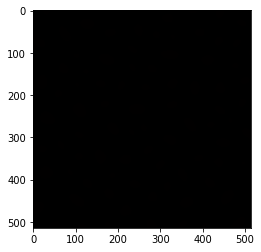

In [7]:
#Leo la imagen
#im = get_image(r'C:\Users\laran\Documents\Física\Procesamiento de Imagenes\PDI_Datos_AFM_Gotas\AFM_Gotas_png\imagen_prueba2.png')
im = get_image('/content/drive/MyDrive/Imagenes PDI/imagen_prueba2.png') #Esto lo uso en colab

im_YIQ = rgbatoyiq(im) #la convierto a YIQ

#Binarizo la imagen
im_YIQ = np.where(im_YIQ <= 0.5, 0, 1)

plt.imshow(im_YIQ) 
plt.show()

im_YIQ_new = np.copy(im_YIQ) # paso por VALOR no por referencia (sino las variables son SIEMPRE iguales)

gotas_list = [] #la inicializo fuera del while pq sino cada vez que borro una gota, esto vuelve a cero, y no me sirve
perimetros_tot_gota =[] #también tengo que inizializar afuera del while, sino se me borra la info
i_values = [-1, 0, 1]
j_values = [-1, 0, 1]
rcm_gotas = []

Analizo los píxeles

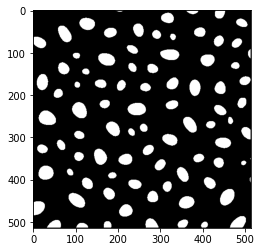

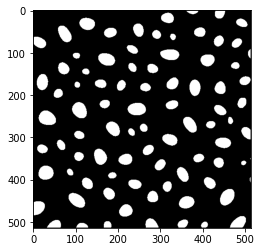

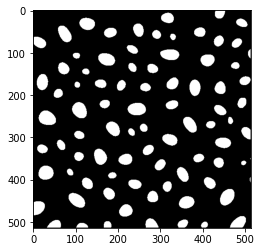

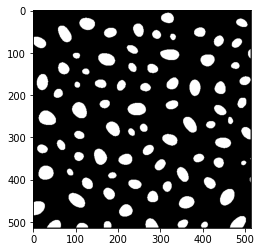

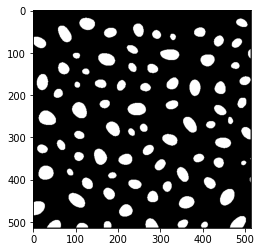

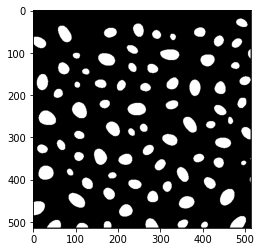

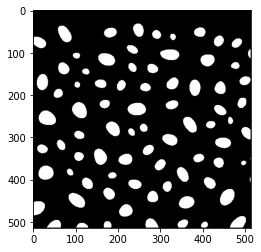

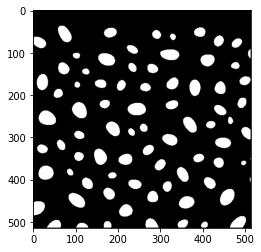

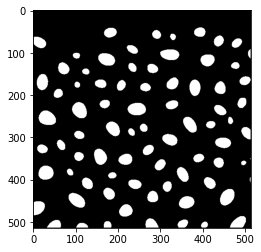

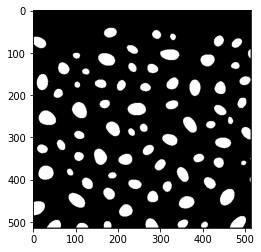

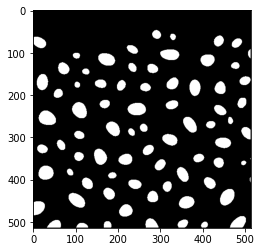

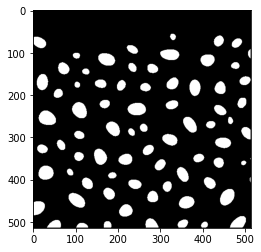

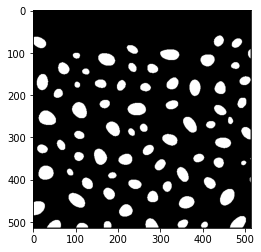

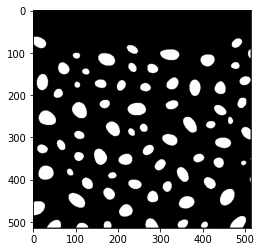

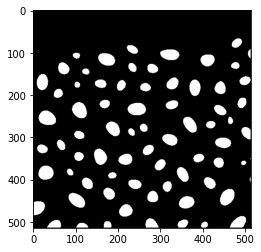

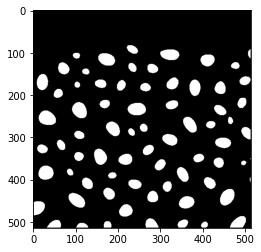

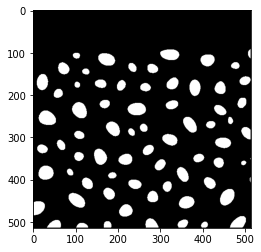

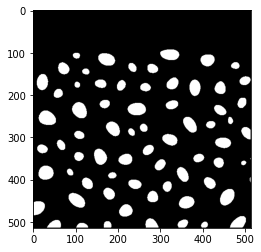

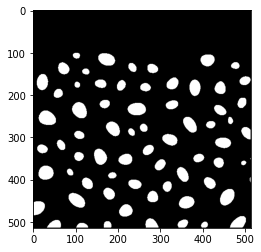

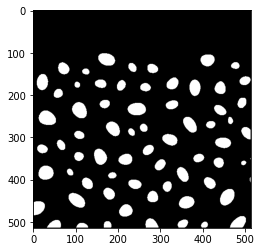

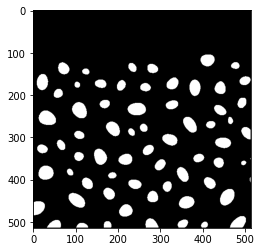

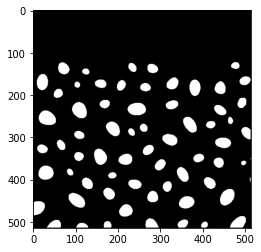

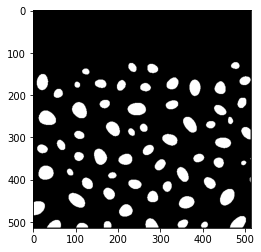

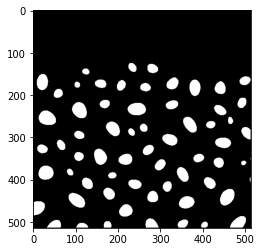

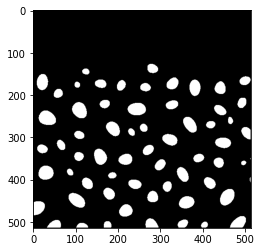

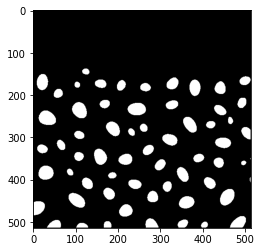

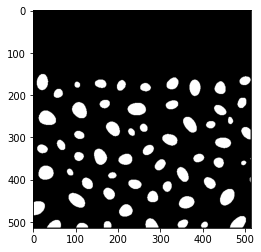

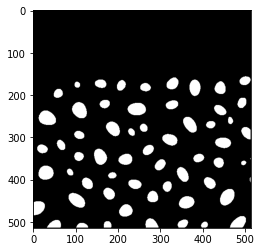

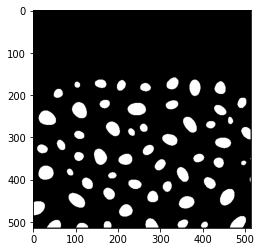

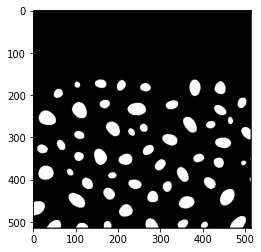

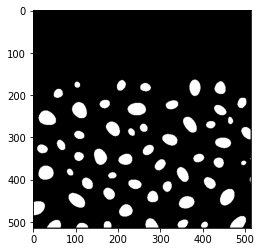

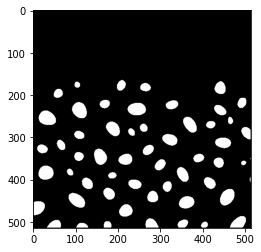

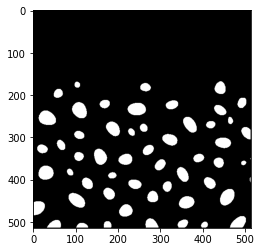

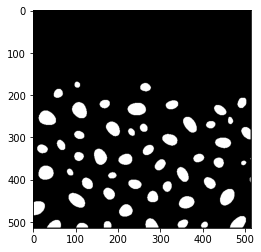

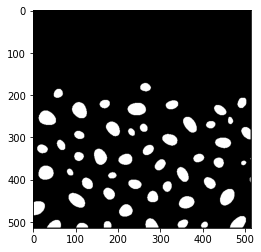

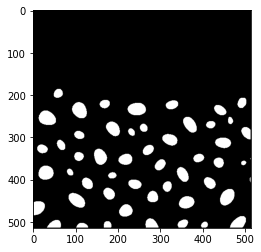

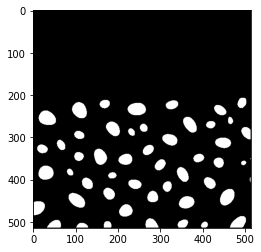

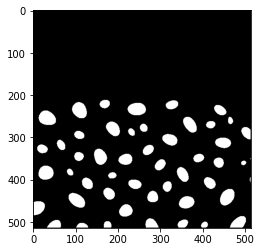

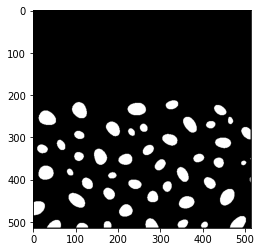

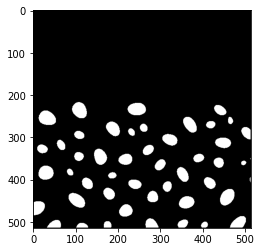

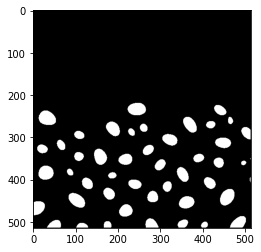

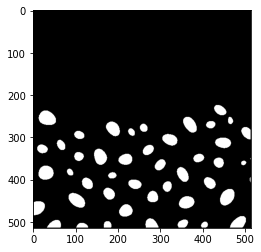

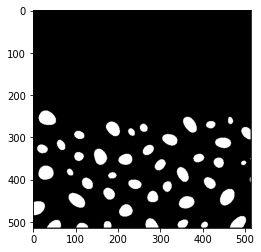

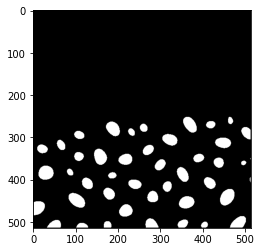

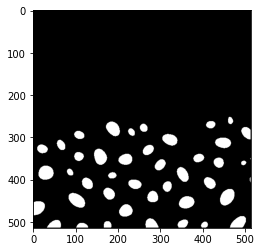

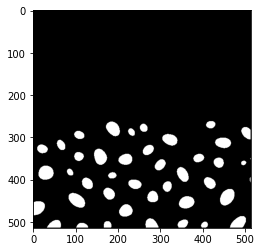

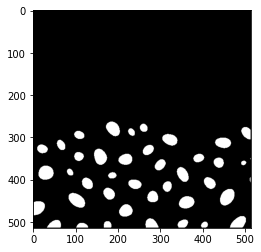

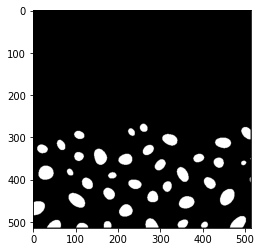

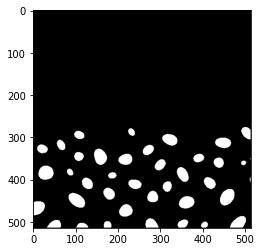

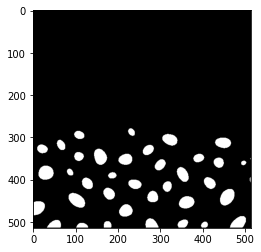

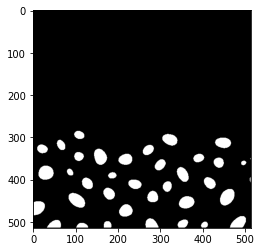

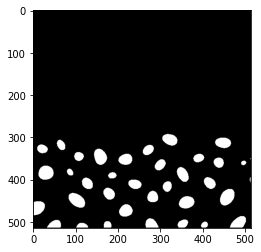

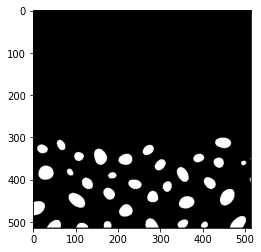

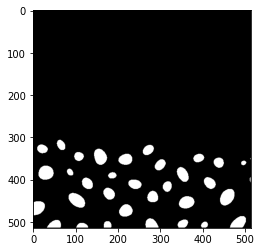

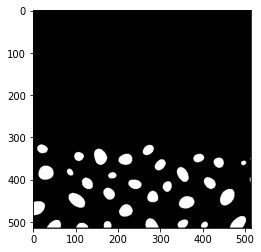

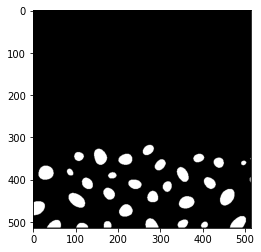

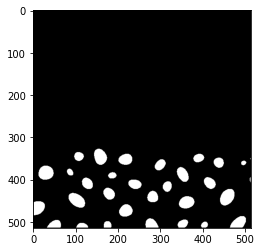

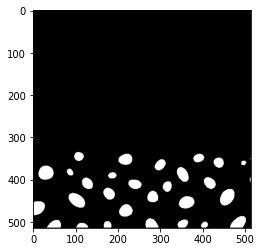

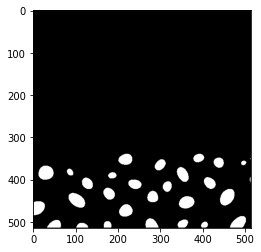

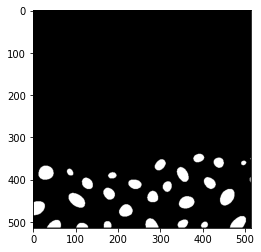

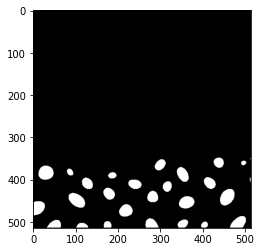

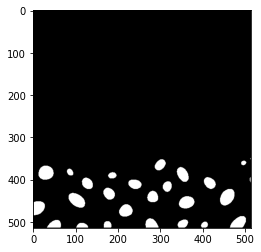

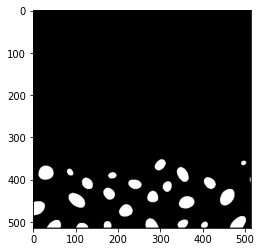

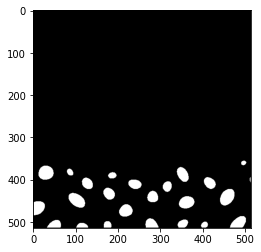

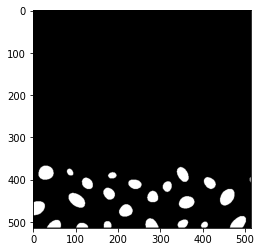

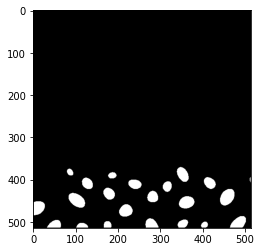

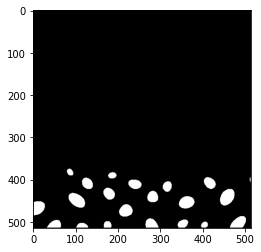

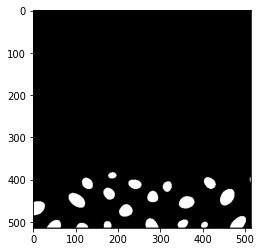

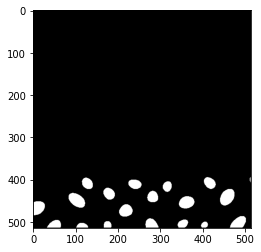

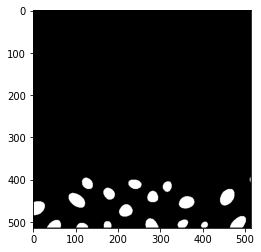

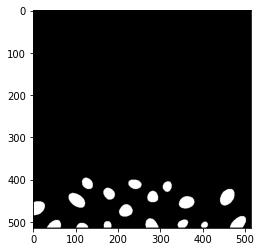

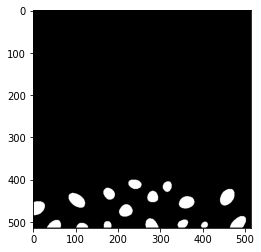

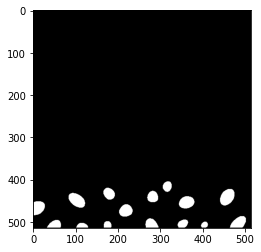

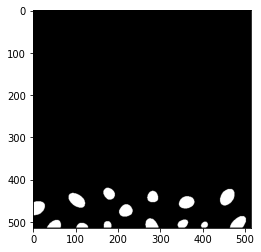

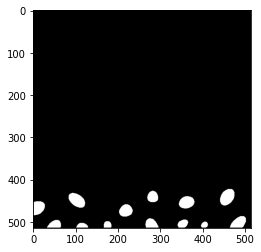

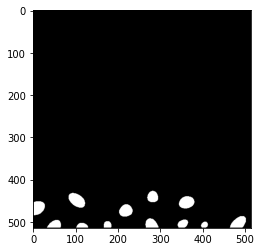

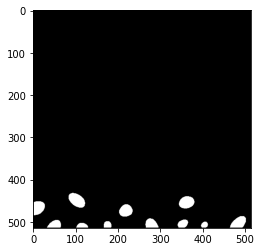

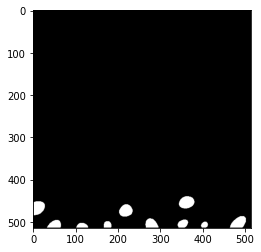

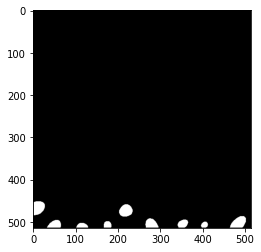

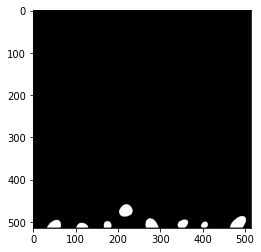

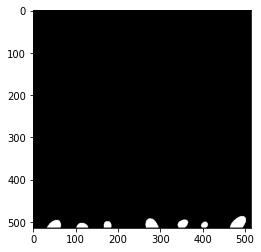

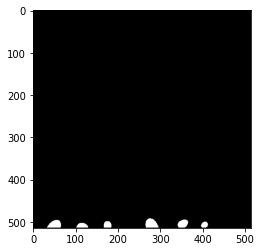

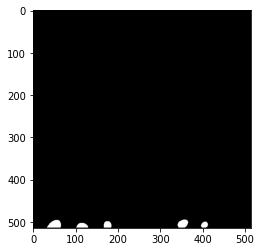

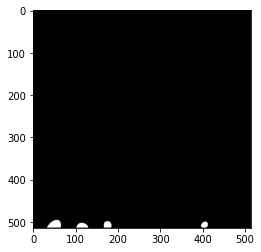

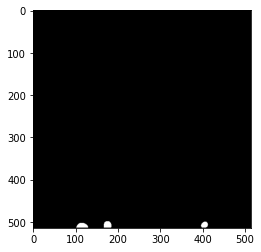

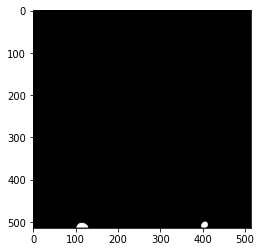

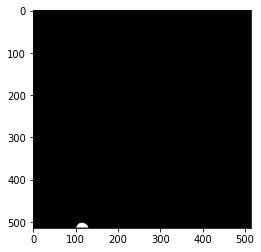

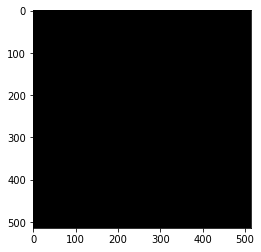

In [4]:
while im_YIQ_new[:,:,0].any() == 1: #el código termina cuando ya no tengo pixeles blancos en la imagen (no hay más manchas)
    
    pixel_analisis(im, i_values, j_values, gotas_list, rcm_gotas, perimetros_tot_gota)

Terminado el análisis de píxeles, calculo propiedades geométricas de las gotas

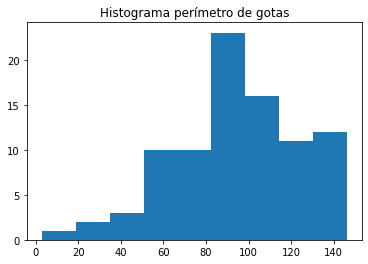

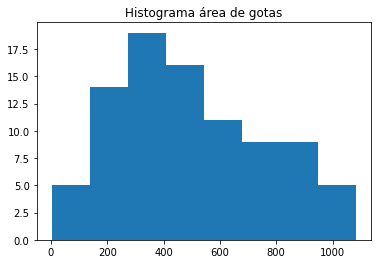

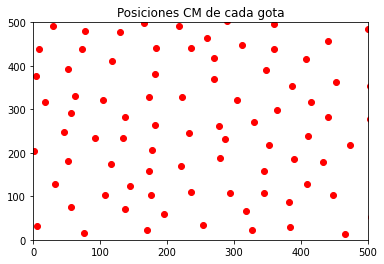

In [6]:
#Cálculo y ploteo del perímetro de cada gota
plot1 = plt.figure(1)
plt.hist(perimetros_tot_gota, bins='auto')  #mi histograma está en el TP4 en colab
plt.title("Histograma perímetro de gotas")
    
nro_gotas = len(gotas_list) #cuento el nro de gotas

#Cálculo el área y rcm de cada gota
area_gotas = [None]*nro_gotas #creo una matriz del mismo tamaño que nro_gotas para poder recorrerla en el for que sigue
rcm_gotas = [None]*nro_gotas

for gota in range(0, len(gotas_list)):
    area_gotas[gota] = len(gotas_list[gota]) #creo una matriz con el área de cada gota para despues poder hacer el histograma de áreas

    rcm_gotas[gota] = np.mean(np.array(gotas_list[gota]), axis=0) #array con el CM de cada gota

rcm_gotas = np.array(rcm_gotas) #lo convierto en array para poder plotear fácil
    
#Ploteo el área de cada gota
plot2 = plt.figure(2)
plt.hist(area_gotas, bins='auto')  #mi histograma está en el TP4 en colab
plt.title("Histograma área de gotas")

#Ploteo el CM de cada gota
plot3 = plt.figure(3)
plt.plot(rcm_gotas[:,0], rcm_gotas[:,1], 'ro')
plt.axis([0, 500, 0, 500])
plt.title('Posiciones CM de cada gota')
plt.show()